In [1]:
import matplotlib.pyplot as plt
import autograd
import autograd.numpy as np
import autograd.scipy as sp
import autograd.misc.optimizers
import numpy
from tqdm import tqdm

In [2]:
def u1(z, N=1):
    # z is data n x m x 2
    # N is normalizing constant
    exp_factor = 1/2*((np.linalg.norm(z, axis=2) - 2)/0.4)**2 - \
                 np.log(np.exp(-1/2*((z[:,:,0] - 2)/0.6)**2) + np.exp(-1/2*((z[:,:,0] + 2)/0.6)**2))
    return N * np.exp(-exp_factor)

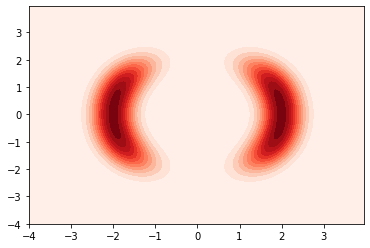

In [3]:
X, Y = numpy.mgrid[-4:4:0.05, -4:4:0.05]
dat = np.dstack((X, Y))
U_z1 = u1(dat)

fig, ax = plt.subplots()
ax.contourf(X, Y, U_z1, cmap='Reds', levels=15)
plt.show()

In [4]:
# Parameters

h = np.tanh

q_0_mu = np.array([0,0])
q_0_sigma = 1
D = q_0_mu.shape[0]
num_samples = 1000

num_flows = 4
lambda_flows = np.array([np.array([1., 0., 4., 5., 0.])]*num_flows)

m = 20000
step_size = .01


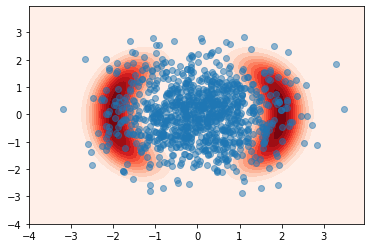

In [5]:
# Samples from initial distribution
samples = np.random.multivariate_normal(q_0_mu, q_0_sigma*np.eye(D), num_samples)

fig, ax = plt.subplots()
ax.contourf(X, Y, U_z1, cmap='Reds', levels=15)
ax.scatter(samples[:, 0], samples[:, 1], alpha=.5)
plt.show()

In [6]:
# lambda u, w, b

# Flow multiple times
def flow_samples(lambda_flows, z, h):
    D = (lambda_flows.shape[1]-1)//2
    for lambda_flow in lambda_flows:
        z = flow_once(lambda_flow, z, h)
    return z

# Flow once
def flow_once(lambda_flow, z, h):
    D = (lambda_flow.shape[0]-1)//2
    z @ lambda_flow[D:2*D].reshape(-1, 1)
    return z + h((z @ lambda_flow[D:2*D].reshape(-1, 1))+lambda_flow[-1]) @ lambda_flow[:D].reshape(1, -1)

# Psi
def psi(lambda_flow, z, h):
    D = (lambda_flow.shape[0]-1)//2
    return (1-h((z @ lambda_flow[D:2*D].reshape(-1, 1))+lambda_flow[-1])**2) * lambda_flow[D:2*D]

In [7]:
# Calculate energy bound
def energy_bound(lambda_flows, z, h, beta=1.):
    D = (lambda_flows.shape[1]-1)//2
    initial_exp = np.mean(np.log(sp.stats.norm.pdf(z, loc=q_0_mu, scale=np.sqrt(q_0_sigma))))
    joint_exp = beta*np.mean(np.log(u1(flow_samples(lambda_flows, z, h).reshape(1, -1, 2))))
    flow_exp = 0
    for lambda_flow in lambda_flows:
        flow_exp += np.mean(np.log(np.abs(1 + np.dot(psi(lambda_flow, z, h), lambda_flow[:D]))))
        z = flow_once(lambda_flow, z, h)
    return initial_exp - joint_exp - flow_exp

In [8]:
def get_joint_exp(lambda_flows, z, h):
    return np.mean(np.log(u1(flow_samples(lambda_flows, z, h).reshape(1, -1, 2))))

In [9]:
def get_flow_exp(lambda_flows, z, h):
    D = (lambda_flows.shape[1]-1)//2
    flow_exp = 0
    for lambda_flow in lambda_flows:
        flow_exp += np.mean(np.log(np.abs(1 + np.dot(psi(lambda_flow, z, h), lambda_flow[:D]))))
        z = flow_once(lambda_flow, z, h)
        
    return flow_exp

In [10]:
grad_energy_bound = autograd.grad(energy_bound)

  0%|          | 0/20000 [00:00<?, ?it/s]

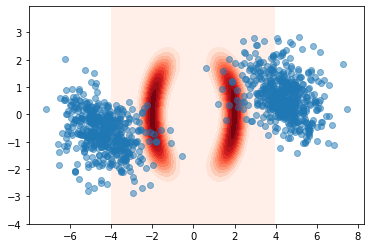

 10%|█         | 2000/20000 [00:29<04:07, 72.85it/s]

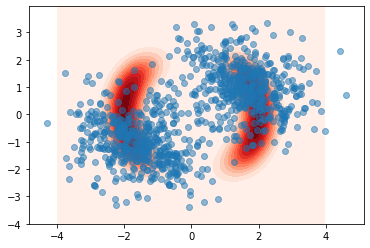

 20%|█▉        | 3996/20000 [01:00<03:56, 67.66it/s]

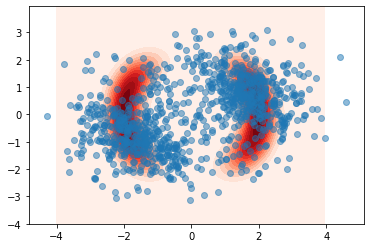

 30%|██▉       | 5999/20000 [01:31<03:27, 67.51it/s]

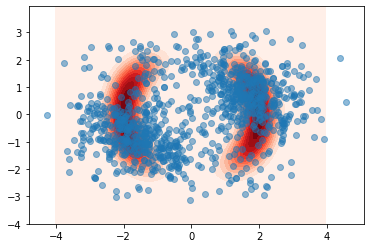

 40%|███▉      | 7994/20000 [02:01<03:01, 66.32it/s]

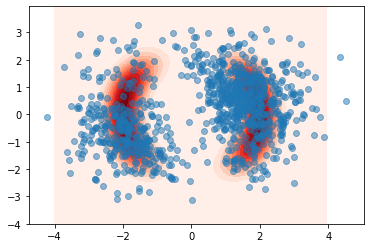

 50%|████▉     | 9999/20000 [02:31<02:26, 68.24it/s]

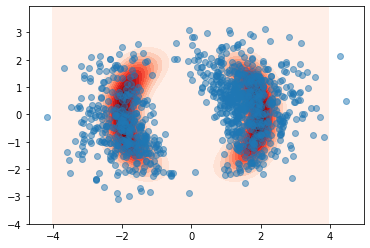

 60%|█████▉    | 11995/20000 [03:02<01:57, 68.29it/s]

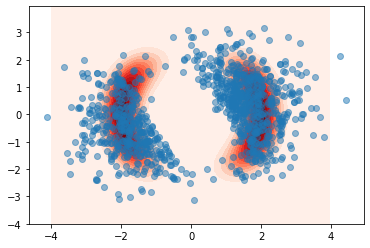

 70%|██████▉   | 13999/20000 [03:32<01:32, 64.60it/s]

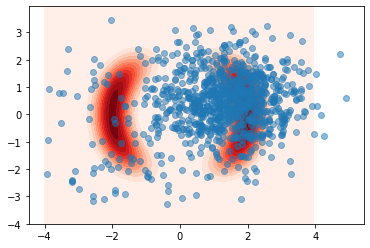

 80%|███████▉  | 15994/20000 [04:02<01:02, 63.81it/s]

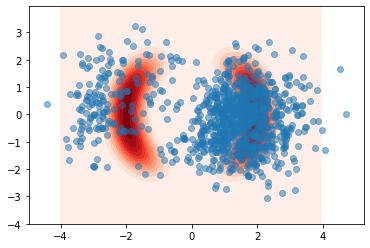

 90%|████████▉ | 17993/20000 [04:31<00:28, 71.20it/s]

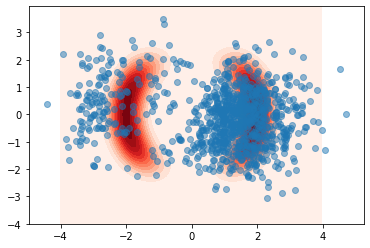

100%|██████████| 20000/20000 [05:01<00:00, 66.28it/s]


In [11]:
energy_hist = np.empty(m)
joint_hist = np.empty(m)
flow_hist = np.empty(m)
lambda_hist = np.empty((m, *lambda_flows.shape))
samples_flowed = samples
for i in tqdm(range(m)):
    beta = min(1, 0.01+i/10000)
    samples_flowed = flow_samples(lambda_flows, samples, h)
    
    gradient = grad_energy_bound(lambda_flows, samples, h, beta)
    lambda_flows -= step_size*gradient
#     lambda_flows = autograd.misc.optimizers.adam(grad_energy_bound, lambda_flows)
    
    # Debug
    energy_hist[i] = energy_bound(lambda_flows, samples, h)
    joint_hist[i] = get_joint_exp(lambda_flows, samples, h)
    flow_hist[i] = get_flow_exp(lambda_flows, samples, h)
    lambda_hist[i] = lambda_flows
    
    # Plot
    if i % 2000 == 0:
        fig, ax = plt.subplots()
        ax.contourf(X, Y, U_z1, cmap='Reds', levels=15)
        ax.scatter(samples_flowed[:, 0], samples_flowed[:, 1], alpha=.5)
        plt.show()

(-4, 1)

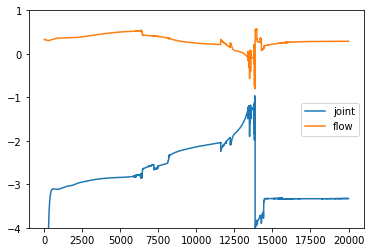

In [12]:
plt.plot(joint_hist, label='joint')
plt.plot(flow_hist, label='flow')
plt.legend()
plt.ylim((-4, 1))